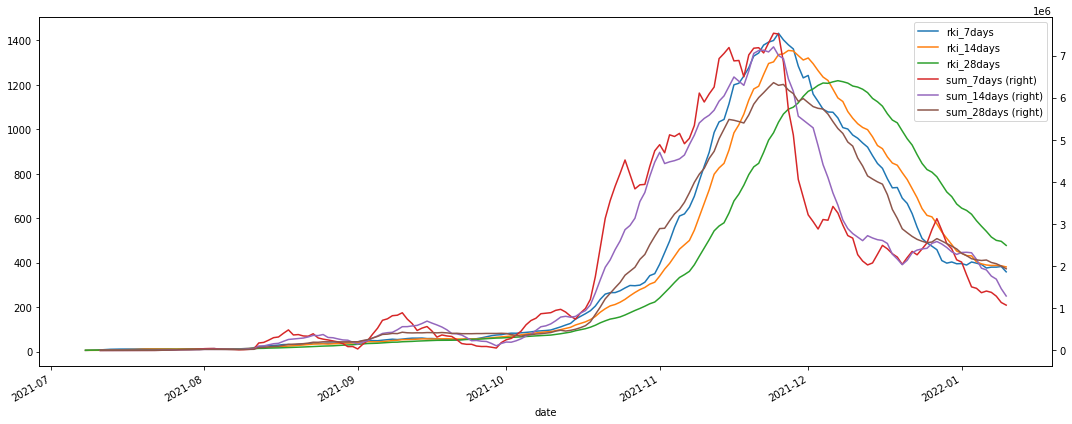

In [28]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [15.0, 6.0]

abw = pd.read_csv(
    "~/user/Downloads/20220502_142656.csv", parse_dates=True
).rename(columns={"Abwasser Täglich": "daily", "__timestamp": "date"}).set_index("date").filter(("daily",)).loc["2021-03-15":]
abw.index = pd.to_datetime(abw.index)
abw.index = abw.index.strftime("%Y-%m-%d")

# rki
rki = pd.read_csv("Dresden_RKI_data.csv").set_index("Refdatum")
rki.rename(columns={"rki_7tage": "rki_7days", "rki_14tage": "rki_14days", "rki_28tage": "rki_28days"}, inplace=True)

# join
df = abw.join(rki)
df = df.dropna()
df.index = pd.to_datetime(df.index)
# varianten
var = pd.read_csv("Dresden_Varianten.csv").set_index("DATE_DRAW")
var = var.filter(("Alpha", "Delta", "Omicron"))
var.index = pd.to_datetime(var.index)
var = var.reindex(df.index)
var = var.interpolate("time", axis=0)

# df = df.loc[var["Alpha"] > 0.5] # Alpha
df = df.loc[var["Delta"] > 0.5] # Delta
df["sum_7days"] = df["daily"].rolling(7, min_periods=1, closed="left").mean() * 7
df["sum_14days"] = df["daily"].rolling(14, min_periods=1, closed="left").mean() * 7
df["sum_28days"] = df["daily"].rolling(28, min_periods=1, closed="left").mean() * 7
df.drop(columns=["daily"], inplace=True)
# df = df.loc[var["Omicron"] > 0.5] # Omicron

df.plot(secondary_y=("sum_7days", "sum_14days", "sum_28days"))
plt.tight_layout()
plt.savefig("delta.png")
plt.show()


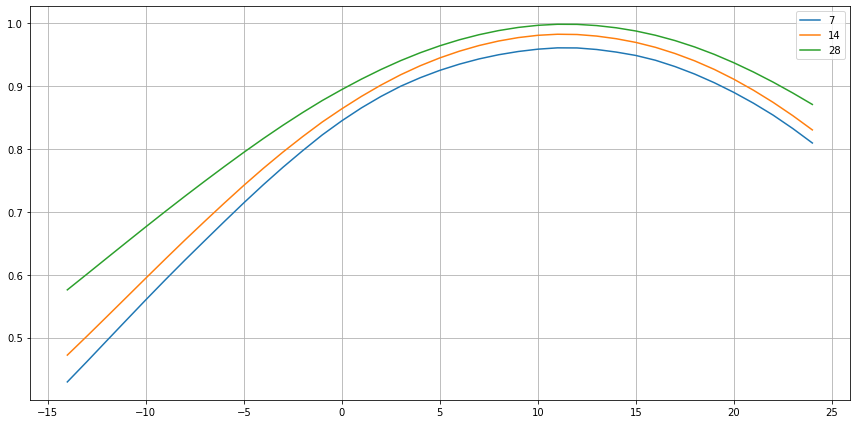

In [32]:
def get_lag(left, right, method="pearson"):
    rng = range(-14, 25)
    rs = []
    for lag in rng:
        right_lagged = df[right].shift(lag)
        lagged_index = df[left].index.intersection(right_lagged.index)
        rs.append(df[left].loc[lagged_index].corr(right_lagged.loc[lagged_index], method=method))
    # rs = [df[left].corr(df[right].shift(lag), method=method) for lag in rng]
    rs = pd.DataFrame(rs, index=rng)
    return rs#.idxmax()[0]

def shift(df):
    df_shifted = df.copy()
    for day in (7, 14, 28):
        lag = get_lag(f"rki_{day}days", f"sum_{day}days")
        df_shifted[f"rki_{day}days"] = df_shifted[f"rki_{day}days"].shift(-lag)
    df_shifted.dropna(inplace=True)
    return df_shifted

rs = [get_lag(f"rki_{day}days", f"sum_{day}days").squeeze() for day in (7, 14, 28)]
rs = pd.DataFrame(rs, index=(7, 14, 28)).transpose()
rs.plot(figsize=(12,6), grid=True)
plt.tight_layout()
plt.savefig("shifting.png")
plt.show()
# pd.DataFrame((rs.max(), rs.idxmax())).transpose()

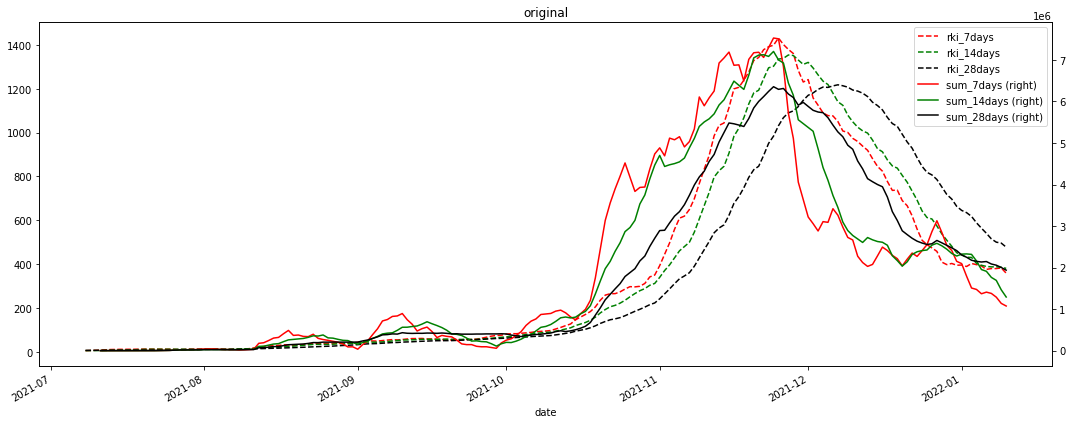

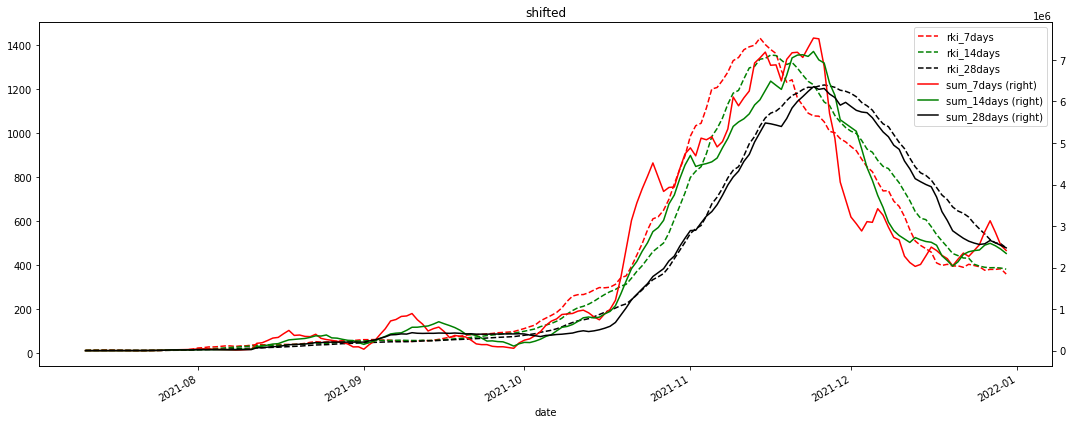

In [41]:
df_shifted = df.copy()
for l, v in rs.idxmax().to_dict().items():
    df_shifted[f"rki_{l}days"] = df_shifted[f"rki_{l}days"].shift(-v)
df_shifted.dropna(inplace=True)
style = {f"rki_{k}days": c + "--" for c, k in zip(("r", "g", "k"), (7, 14, 28))}
style.update({f"sum_{k}days": c + "-" for c, k in zip(("r", "g", "k"), (7, 14, 28))})
# style = {f"rki_{k}days": "--" for k in (7, 14, 28)}
df.plot(secondary_y=("daily", "sum_7days", "sum_14days", "sum_28days"), title="original", style=style)
plt.tight_layout()
df_shifted.plot(secondary_y=("daily", "sum_7days", "sum_14days", "sum_28days"), title="shifted", style=style)
plt.tight_layout()
plt.savefig("shifted.png")
plt.show()

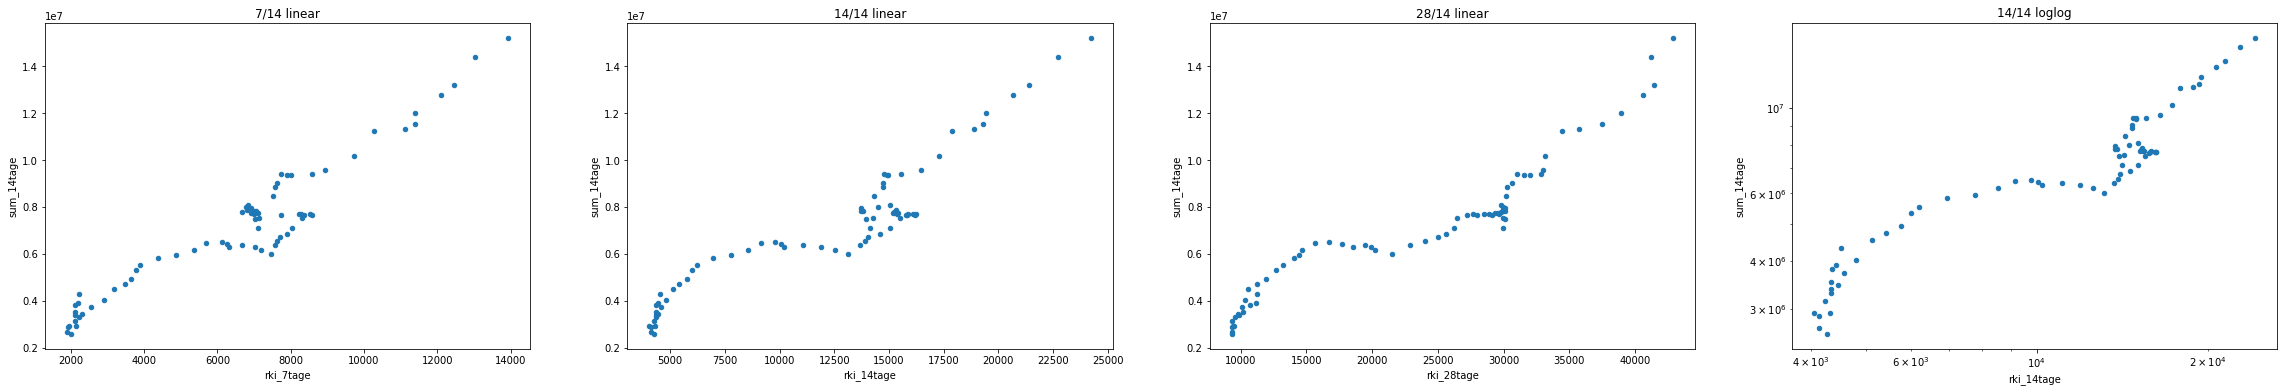

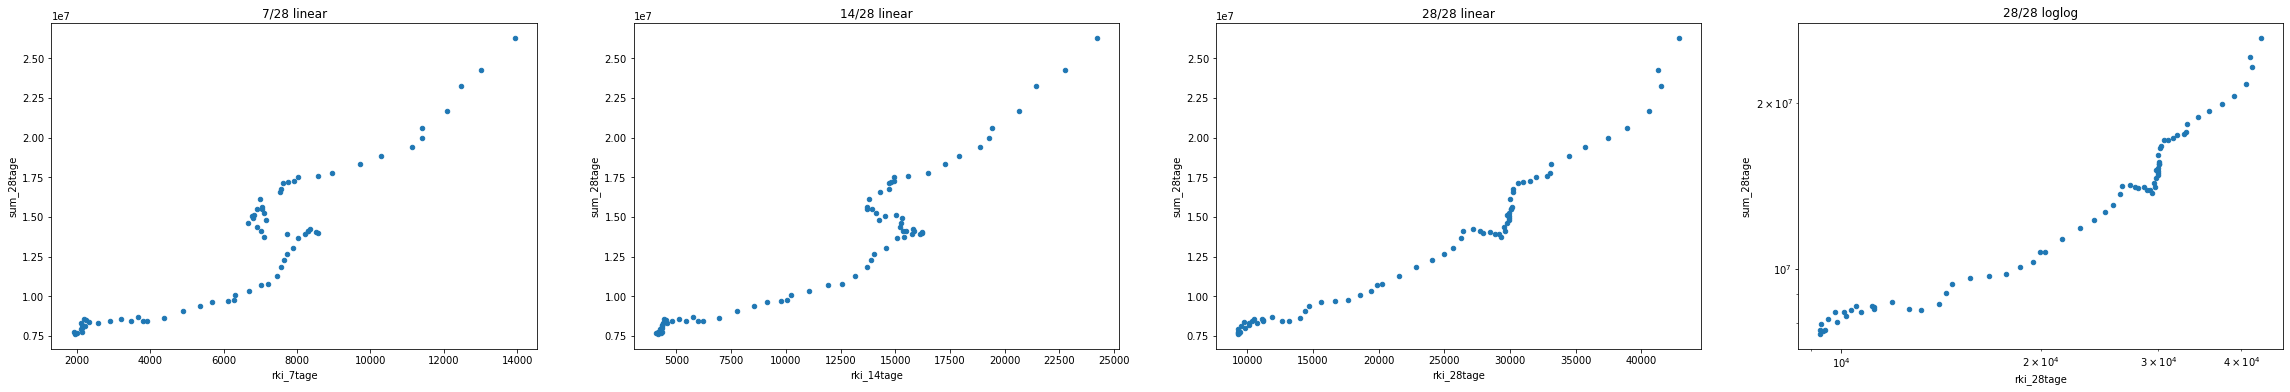

In [80]:
for k in ("14", "28"):
    fig, ax = plt.subplots(1, 4, squeeze=True, figsize=(40, 6))
    df_shifted.plot.scatter(f"rki_7tage", f"sum_{k}tage", title=f"7/{k} linear", ax=ax[0])
    df_shifted.plot.scatter(f"rki_14tage", f"sum_{k}tage", title=f"14/{k} linear", ax=ax[1])
    df_shifted.plot.scatter(f"rki_28tage", f"sum_{k}tage", title=f"28/{k} linear", ax=ax[2])
    # df_shifted.plot.scatter(f"rki_{k}tage", f"sum_{k}tage", logx=True, title=f"{k} semilog_x", ax=ax[1])
    # df_shifted.plot.scatter(f"rki_{k}tage", f"sum_{k}tage", logy=True, title=f"{k} semilog_y", ax=ax[2])
    df_shifted.plot.scatter(f"rki_{k}tage", f"sum_{k}tage", loglog=True, title=f"{k}/{k} loglog", ax=ax[3])
plt.show()


In [76]:
from scipy.stats import pearsonr
from scipy.stats import spearmanr
print("pearsonr 28/28:", pearsonr(df_shifted["rki_28tage"], df_shifted["sum_28tage"]))
print("spearmanr 28/28:", spearmanr(df_shifted["rki_28tage"], df_shifted["sum_28tage"]))
df_shifted.corr()

pearsonr 28/28: (0.9729321399099715, 6.53069928256145e-47)
spearmanr 28/28: SpearmanrResult(correlation=0.9904664938911517, pvalue=7.164632515724041e-63)


,sum_7tage,daily,sum_14tage,sum_28tage,rki_7tage,rki_14tage,rki_28tage
sum_7tage,1.000000,0.827316,0.955317,0.921414,0.916933,0.871986,0.908510
daily,0.827316,1.000000,0.793836,0.777937,0.736128,0.704141,0.740520
sum_14tage,0.955317,0.793836,1.000000,0.961408,0.949129,0.932569,0.963179
sum_28tage,0.921414,0.777937,0.961408,1.000000,0.910045,0.928751,0.972932
rki_7tage,0.916933,0.736128,0.949129,0.910045,1.000000,0.975876,0.960988
rki_14tage,0.871986,0.704141,0.932569,0.928751,0.975876,1.000000,0.983556
rki_28tage,0.908510,0.740520,0.963179,0.972932,0.960988,0.983556,1.000000


score 0.8696845370475039
0.0019235335712960743 -1569.507705160975


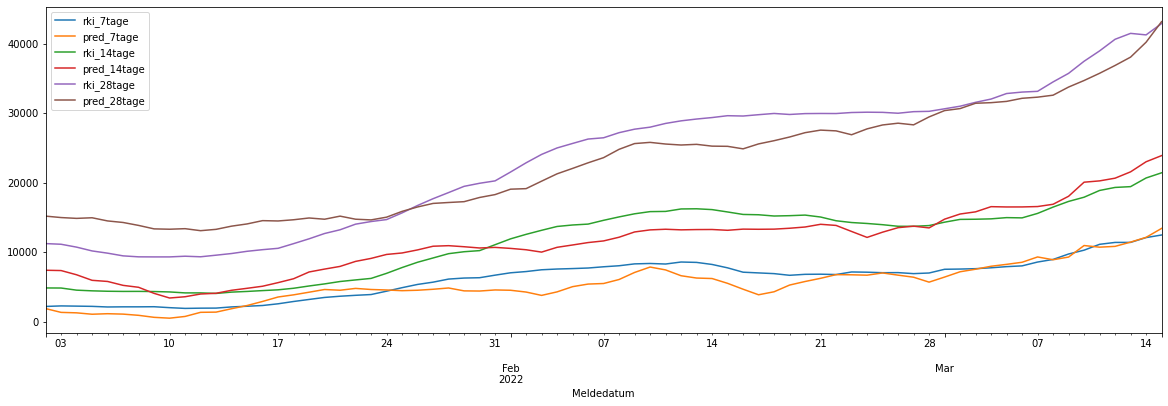

In [77]:
# Linear regression
from sklearn.linear_model import LinearRegression
k = 14
X = df_shifted[f"sum_{k}tage"].to_numpy().reshape(-1, 1)
y = df_shifted[f"rki_{k}tage"].to_numpy().reshape(-1, 1)
reg = LinearRegression().fit(X, y)
print("score", reg.score(X, y))
c, i = reg.coef_[0][0], reg.intercept_[0]
print(c, i)
df_pred = df_shifted.copy()
df_pred["pred_28tage"] = i + df_pred["sum_28tage"] * c
df_pred["pred_14tage"] = i + df_pred["sum_14tage"] * c
df_pred["pred_7tage"] = i + df_pred["sum_7tage"] * c
df_pred.filter(("rki_7tage", "pred_7tage", "rki_14tage", "pred_14tage","rki_28tage", "pred_28tage")).plot(figsize=(20,6))
plt.show()